In [97]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [105]:
import pandas as pd
import numpy as np
import utils


df = utils.load_data()
df = df.reset_index().rename(columns={'DATE': 'ds', "US_TB_YIELD_10YRS": "y"})
df["unique_id"] = 1
df = df.interpolate()
df = df.dropna()
df.describe()


train_df = df[df['ds'] < "2016-01-01"]

In [113]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, TFT
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.auto import AutoNHITS
import optuna


horizon = 12 # year-ahead monthly forecast


hist_exog_list = ["FFED", "US_PERSONAL_SPENDING_PCE", "US_CPI", "US_UNEMPLOYMENT_RATE"]




def config_nhits(trial):
    return {
        "max_steps": 50,                                                                                               # Number of SGD steps
        "input_size": trial.suggest_int("input_size", 6, 36),                                                                                               # Size of input window
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
        "n_pool_kernel_size": trial.suggest_categorical("n_pool_kernel_size", [[2, 2, 2], [16, 8, 1]]),                 # MaxPool's Kernelsize
        "n_freq_downsample": trial.suggest_categorical("n_freq_downsample", [[168, 24, 1], [24, 12, 1], [1, 1, 1]]),    # Interpolation expressivity ratios
    }


models = [
    # NHITS(
    #     h = horizon,
    #     input_size= 24,
    #     max_steps=50,
    #     futr_exog_list=[],
    #     hist_exog_list=hist_exog_list,
    #     stat_exog_list=[],
    #     scaler_type="robust",
    #     loss=MQLoss(),
    # ),
    AutoNHITS(h=horizon, config=config_nhits, loss=MQLoss(), backend="optuna", search_alg=optuna.samplers.TPESampler(), num_samples=20)
    # TFT(
    #     h = horizon,
    #     input_size= 24,
    #     max_steps=50,
    #     futr_exog_list=[],
    #     hist_exog_list=hist_exog_list,
    #     stat_exog_list=[],
    #     scaler_type="robust",
    #     loss=MQLoss(),

    #     # hidden_size=
    #     # dropout= # dropout of inputs VSNs.
    #     # n_head= # number of attention heads in temporal fusion decoder.
    #     # attn_dropout=  # dropout of fusion decoder’s attention layer.
    #     # grn_activation= #  [‘ReLU’, ‘Softplus’, ‘Tanh’, ‘SELU’, ‘LeakyReLU’, ‘Sigmoid’, ‘ELU’, ‘GLU’]
    #     # learning_rate=
    #     # num_lr_decays= #  Number of learning rate decays, evenly distributed across max_steps.
    #     # batch_size=
    #     # windows_batch_size= # windows sampled from rolled data, default uses all.
    #     # inference_windows_batch_size= # int=-1, number of windows to sample in each inference batch, -1 uses all.

    # )
]

MODEL_NAME = "AutoNHITS"



In [114]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # Use this to disable training prints from optuna

nf = NeuralForecast(models=models, freq="ME")
# cv_df = nf.cross_validation(train_df, n_windows=3, step_size=1)
cv_df = nf.fit(train_df)

/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
/Users/

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
5         Non-trainable params
2.5 M     Total params
10.016    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2130397913.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),                                         # Initial Learning rate
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
Seed set to 1
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
5         Non-trainable params
2.5 M     Total params
9.839     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.


# See hp search result

In [115]:
results = nf.models[0].results.trials_dataframe()
results.drop(columns='user_attrs_ALL_PARAMS').sort_values("value", ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_input_size,params_learning_rate,params_n_freq_downsample,params_n_pool_kernel_size,user_attrs_METRICS,state
15,15,0.030761,2024-12-25 13:05:03.811744,2024-12-25 13:05:06.479367,0 days 00:00:02.667623,25,0.000010,"[24, 12, 1]","[2, 2, 2]","{'loss': tensor(0.0308), 'train_loss': tensor(...",COMPLETE
12,12,0.030870,2024-12-25 13:04:55.619101,2024-12-25 13:04:58.286791,0 days 00:00:02.667690,35,0.000011,"[168, 24, 1]","[2, 2, 2]","{'loss': tensor(0.0309), 'train_loss': tensor(...",COMPLETE
13,13,0.033925,2024-12-25 13:04:58.287326,2024-12-25 13:05:01.048206,0 days 00:00:02.760880,26,0.000011,"[168, 24, 1]","[2, 2, 2]","{'loss': tensor(0.0339), 'train_loss': tensor(...",COMPLETE
10,10,0.036845,2024-12-25 13:04:50.166092,2024-12-25 13:04:52.880795,0 days 00:00:02.714703,30,0.000011,"[168, 24, 1]","[2, 2, 2]","{'loss': tensor(0.0368), 'train_loss': tensor(...",COMPLETE
1,1,0.037782,2024-12-25 13:04:25.153681,2024-12-25 13:04:27.915968,0 days 00:00:02.762287,36,0.000036,"[168, 24, 1]","[2, 2, 2]","{'loss': tensor(0.0378), 'train_loss': tensor(...",COMPLETE
11,11,0.038619,2024-12-25 13:04:52.881321,2024-12-25 13:04:55.618566,0 days 00:00:02.737245,30,0.000014,"[168, 24, 1]","[2, 2, 2]","{'loss': tensor(0.0386), 'train_loss': tensor(...",COMPLETE
18,18,0.039430,2024-12-25 13:05:12.042889,2024-12-25 13:05:14.688939,0 days 00:00:02.646050,22,0.000017,"[24, 12, 1]","[16, 8, 1]","{'loss': tensor(0.0394), 'train_loss': tensor(...",COMPLETE
5,5,0.039467,2024-12-25 13:04:36.480044,2024-12-25 13:04:39.280874,0 days 00:00:02.800830,35,0.000024,"[24, 12, 1]","[16, 8, 1]","{'loss': tensor(0.0395), 'train_loss': tensor(...",COMPLETE
17,17,0.039675,2024-12-25 13:05:09.156192,2024-12-25 13:05:12.042381,0 days 00:00:02.886189,32,0.000023,"[24, 12, 1]","[2, 2, 2]","{'loss': tensor(0.0397), 'train_loss': tensor(...",COMPLETE
2,2,0.041001,2024-12-25 13:04:27.916497,2024-12-25 13:04:30.895955,0 days 00:00:02.979458,7,0.000021,"[168, 24, 1]","[2, 2, 2]","{'loss': tensor(0.0410), 'train_loss': tensor(...",COMPLETE


In [102]:
from collections import defaultdict

def make_forecasts():
    forecasts = defaultdict(pd.Series)

    for time_step in df[df["ds"] >= "2016-01-01"]["ds"].unique():
        df_train = df[df["ds"] < time_step]
        df_test = df[df["ds"] == time_step]
        pred = nf.predict(df_train)
        pred = pred.set_index("ds")

        # print(time_step)
        # print(pred)

        # point_forecast = pred["TFT-median"].values[0]
        # print(point_forecast)

        pred["y"] = df_test["y"].values[0]
        pred["error"] = pred["y"] - pred[f"{MODEL_NAME}-median"]



        for i in range(horizon):
            forecasts[i] = pd.concat([forecasts[i], pred.iloc[[i]]])


    return forecasts

forecasts = make_forecasts()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2351714822.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  forecasts[i] = pd.concat([forecasts[i], pred.iloc[[i]]])
/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_14459/2351714822.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude 

Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


# Plot forecasts

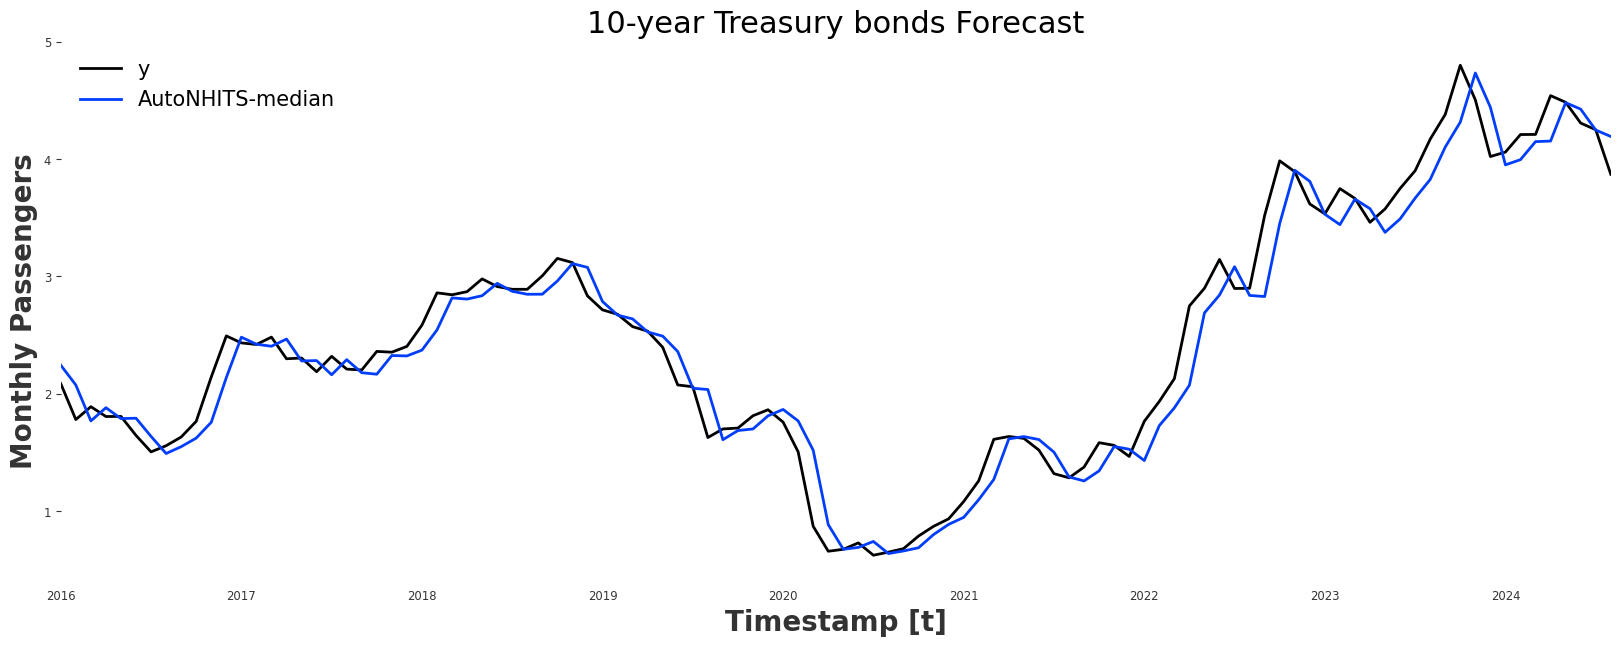

In [103]:
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plot_df = df.set_index("ds").join(forecasts[0].drop(columns=["y"]))
plot_df = plot_df[plot_df.index >= "2016-01-01"]
plot_df[["y",f"{MODEL_NAME}-median"]].plot(ax=ax, linewidth=2)

ax.set_title('10-year Treasury bonds Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
plt.show()

# Get evaluation metric per horizon

In [104]:
for i, fore in forecasts.items():
    print(i)
    mae = fore["error"].abs().mean()
    print(f"\tMAE: {mae}")

    mape = (fore["error"].abs() / fore["y"]).mean()
    print(f"\tMAPE: {mape}")

    rmse = np.sqrt((fore["error"]**2).mean())
    print(f"\tRMSE: {rmse}")
    print("-"*20)

0
	MAE: 0.15790405869483948
	MAPE: 0.07450695335865021
	RMSE: 0.2182297259569168
--------------------
1
	MAE: 0.16840921342372894
	MAPE: 0.08008448779582977
	RMSE: 0.22579659521579742
--------------------
2
	MAE: 0.15545311570167542
	MAPE: 0.07364554703235626
	RMSE: 0.21423150599002838
--------------------
3
	MAE: 0.15882007777690887
	MAPE: 0.07606831192970276
	RMSE: 0.2134489119052887
--------------------
4
	MAE: 0.15658807754516602
	MAPE: 0.07445678114891052
	RMSE: 0.2163088321685791
--------------------
5
	MAE: 0.16063213348388672
	MAPE: 0.07811354100704193
	RMSE: 0.21585266292095184
--------------------
6
	MAE: 0.16186141967773438
	MAPE: 0.07735814154148102
	RMSE: 0.21518386900424957
--------------------
7
	MAE: 0.16082166135311127
	MAPE: 0.0778660923242569
	RMSE: 0.21611809730529785
--------------------
8
	MAE: 0.16208666563034058
	MAPE: 0.07822433859109879
	RMSE: 0.21872273087501526
--------------------
9
	MAE: 0.19467908143997192
	MAPE: 0.09703890234231949
	RMSE: 0.2467063069343